In [1]:
from b_field import structured_field
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import simps
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MaxNLocator
from gammaALPs.nel.icm import NelICM
from scipy.spatial.transform import Rotation as R_
%matplotlib notebook

In [2]:
def cart_to_sphere(x2, y2, z2):
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    theta2 = np.arccos(z2 / r2)
    phi2 = np.arctan2(y2, x2)
    return r2, theta2, phi2

def sphere_to_cart(r, theta, phi):
    x1 = r * np.sin(theta) * np.cos(phi)
    y1 = r * np.sin(theta) * np.sin(phi)
    z1 = r * np.cos(theta)
    return x1, y1, z1


alpha = 5.7634591968
c = 1
F_0 = c * (alpha * np.cos(alpha) - np.sin(alpha)) * alpha**2
norm_ = np.sqrt((3 * F_0 + alpha**5)**2) * 2 / (3 * alpha**2)

def trafo(r, theta, phi):
    '''Returns trafo used for vector fields, i.e. Field A cartesian = S * Field A spherical. S is returned'''
    mat = np.array([[np.sin(theta) * np.cos(phi), np.cos(theta) * np.cos(phi), -np.sin(phi)],
                    [np.sin(theta) * np.sin(phi), np.cos(theta) * np.sin(phi), np.cos(phi)],
                    [np.cos(theta), -np.sin(theta), 0]])
        #outdata[c, :, :] = mat[:, :]
    
    return mat


def rotation(n, x, angle):
    return n * np.inner(n, x) + np.cos(angle) * np.cross(np.cross(n, x), n) + np.sin(angle) * np.cross(n, x)

def cart_rotation(alpha, beta):
    rot_x = np.array([[1,             0,              0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha),  np.cos(alpha)]])
    rot_y = np.array([[ np.cos(beta), 0, np.sin(beta)],
                      [            0, 1,            0],
                      [-np.sin(beta), 0, np.cos(beta)]])
    rot_z = np.array([[np.cos(beta), -np.sin(beta), 0],
                      [np.sin(beta),  np.cos(beta), 0],
                      [           0,             0, 1]])
    return rot_x, rot_z

def b_r(r, theta):
    
    zero_val = - np.cos(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = 2 * np.cos(theta) * f(r) / r**2
    if r > 1:
        val = 0
    return b0 / norm_ * val
    

def b_theta(r, theta):
    zero_val = np.sin(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = - np.sin(theta) * f_prime(r) / r
    if r > 1:
        val = 0
    return b0 / norm_ * val


def b_phi(r, theta):
    zero_val = 0
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = alpha * np.sin(theta) * f(r) / r
    if r > 1:
        val = 0
    return b0 / norm_ * val


def f(r):
    return c * (alpha * np.cos(alpha * r) - np.sin(alpha * r) / r) \
           - F_0 * r**2 / alpha**2


def f_prime(r):
    return c * ( - alpha**2 * np.sin(alpha * r) \
                - alpha * np.cos(alpha * r) / r \
                + np.sin(alpha * r) / r**2) \
               - 2 * F_0 * r / alpha**2

def B_sphere(x1, x2, x3, sys='cart'):
    if sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    #print(r, theta, phi)
    return np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])

def B_cart(x1, x2, x3, sys='cart'):
    if sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif sys == 'sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    B_sph = B_sphere(r, theta, phi, sys='sph')
    #print(B_sph)
    t = trafo(r, theta, phi)
    #print(B_sph.shape)
    #print(t)
    B_c = np.matmul(trafo(r, theta, phi), B_sph.transpose()).transpose()
    return B_c
    

def rotation_measure(z, b_par, nel):
    #print(z)
    #print(b_par)
    #print(nel)
    return 812 * simps(b_par * nel, z)

def projection(field, direction):
    return np.inner(field, direction)

def axis_helper(x):
    l = x.shape[0]
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx / 2, x[-1] + dx / 2, num=l + 1)


def B(x1, x2, x3, in_sys, out_sys):
    #get input coordinates
    if in_sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif in_sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    
    #calculate bfield
    B = np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])
    #print(B.shape)
    #get output coordinates
    if out_sys == 'sph':
        return B
    elif out_sys == 'cart':
        return np.matmul(trafo(r, theta, phi), B.transpose()).transpose()

#def kpc_to_arcmin()

def B_rot(B, rotvec):
    return np.matmul(rotvec.as_matrix(), B.transpose()).transpose()

In [16]:
def make_3d(theta, phi):
    num=11
    # init electron density model
    nel = NelICM(n0 = 39., n2 = 4.05, r_abell = 500., r_core = 80., r_core2 = 280., beta = 1.2, beta2= 0.58, eta = 0.5)
    
    #convert angles to radians
    theta_ = np.radians(theta)
    phi_ = np.radians(phi)
    
    #get rotation
    #incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))    # tilts symmetry axis around x-axis
    pa = R_.from_rotvec(phi_ * np.array([0, 0, 1]))        # rotates around z axis, position angle phi
    
    incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))
    incl = R_.from_rotvec(B_rot(incl.as_rotvec(), pa))
    
    #dipole
    dipole = R * np.array([[0, 0, -1], [0, 0, 1]])   # N, S
    dip_r = B_rot(dipole, incl)
    #dip_r = B_rot(dip_r,)   # somewhat wrong
    
    #init coordinate space
    x = np.linspace(-R, R, num=num, endpoint=True)
    y = np.linspace(-R, R, num=num, endpoint=True)
    z = np.linspace(-R, R, num=num, endpoint=True)   # (0, R) for front half sphere, (-R, R) for full sphere, (-R, 0) for back
    
    #coordinate meshgrid
    xx, yy, zz = np.meshgrid(x, y, z)
    
    #get magnetic field at each point
    B_r = np.zeros((xx.flatten().shape[0], 3))
    c_list = list(zip(xx.flatten(), yy.flatten(), zz.flatten()))
    for c_, (x_, y_, z_) in enumerate(c_list):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        if np.isnan(theta_):
            #check for previous and next few entries for r=0 and take their theta
            print(c_)
            _, theta_, _ = cart_to_sphere(*c_list[c_ + 1])
        #g = B_cart(r_, theta_, phi_, sys='sph')
        #B_C[c_] = g
        b_temp = B_rot(B(r_, theta_, phi_, 'sph', 'cart'), incl)
        B_r[c_] = b_temp #B_rot(b_temp, pa)
    B_r = B_r.reshape(len(x), len(y), len(z), 3)
    #get rm at each projected point in x-y plane
    rm = np.zeros((x.shape[0],  y.shape[0]))
    rr, _, _ = cart_to_sphere(xx, yy, zz)
    NEL = nel(rr)*1e-3
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            rm[i, j] = rotation_measure(z, B_r[i, j, :, 2], NEL[i, j, :])
    #print(rm)
    
    
    #return xx, yy, zz, B_r
    #theta = np.linspace(0, np.pi/2, num=4)
    #phi = np.array([0])
    #phi = np.linspace(0, np.pi/2, num=8)
    #rr, tt, pp = np.meshgrid(r, theta, phi, indexing='ij')
    #print(rr.shape)
    #xx = np.zeros(rr.flatten().shape)
    #xxr = np.zeros(rr.flatten().shape)
    #yy = np.zeros(rr.flatten().shape)
    #yyr = np.zeros(rr.flatten().shape)
    #zz = np.zeros(rr.flatten().shape)
    #zzr = np.zeros(rr.flatten().shape)
    #b = np.zeros((xx.shape[0], 3))
    #br = np.zeros((xx.shape[0], 3))
    #b_fromr = np.zeros((xx.shape[0], 3))
    
    
    #for c_, (r_, t_, p_) in enumerate(zip(rr.flatten(), tt.flatten(), pp.flatten())):
    #    x, y, z = sphere_to_cart(r_, t_, p_)
    #    xx[c_] = x
    #    yy[c_] = y
    #    zz[c_] = z
    #    b[c_] = B(r_, t_, p_, 'sph', 'cart')
    #    b_fromr[c_] = np.matmul(rot.as_matrix(), b[c_].transpose()).transpose()
    #
    #    #print(x, y, z)
    #    vec_r = np.matmul(rot.as_matrix(), np.array([x, y, z]).transpose()).transpose()
    #    #print(vec_r.shape)
    #    xxr[c_] = vec_r[0]
    #    yyr[c_] = vec_r[1]
    #    zzr[c_] = vec_r[2]
    #    br[c_] = B(*vec_r, 'cart', 'cart')




    fig = plt.figure(figsize=(7, 7))
    #ax1 = fig.add_subplot(1, 2, 1)
    
    
    
    #for p in phi:
    #    x, y, z = sphere_to_cart(r, p, theta)
    #    print(x, y, z)
    #    ax.scatter(x, y, z)
    #xx = xx.reshape(rr.shape)
    #yy = yy.reshape(rr.shape)
    #zz = zz.reshape(rr.shape)
    #print(xx)
    #ax.scatter(xx, yy, zz, s=1)
    ax2 = fig.gca(projection='3d')
    #ax1.set_xlabel('$x [\SI{}{\kilo\parsec}]$')
    #ax1.set_ylabel('$y [\SI{}{\kilo\parsec}]$')
    #ax1.set_xlim(-R, R)
    #ax1.set_ylim(-R, R)
    
    
    xh = axis_helper(x)
    yh = axis_helper(y)
    xxh, yyh = np.meshgrid(xh, yh)
    
    
    #ax2.quiver(xx, yy, zz, B_r[:, :, :, 0], B_r[:, :, :, 1], B_r[:, :, :, 2], length=2)
    ax2.plot(dip_r[:, 0], dip_r[:, 1], dip_r[:, 2])
    #ax.scatter(xxr, yyr, zzr, s=1)
    #ax.quiver(xxr, yyr, zzr, br[:, 0], br[:, 1], br[:, 2], length=0.02)
    #ax.quiver(xxr, yyr, zzr, b_fromr[:, 0], b_fromr[:, 1], b_fromr[:, 2], length=0.02)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    #ax2.set_xlim(-100, 100)
    #ax2.set_ylim(-100, 100)
    #ax2.set_zlim(-100, 100)
    #dx = x[1] - x[0]
    #dy = y[1] - y[0]
    #xx, yy = np.meshgrid(x-dx/2, y-dy/2, indexing='ij')
    #xx, yy = np.meshgrid(x, y, indexing='ij')
    B_r = B_r.reshape((x.shape[0],  y.shape[0],  z.shape[0], 3))
    #ax1.set_xlabel('$x$')
    #ax1.set_ylabel('$y$')
    cmap = plt.get_cmap('seismic')
    #x_h = axis_helper(x)
    #y_h = axis_helper(y)
    levels = MaxNLocator(nbins=cmap.N).tick_values(-1e4, 1e4)
    norm = BoundaryNorm(levels, cmap.N)
    #ax.plot(x, y, zs=0, zdir='z', label='curve in (x,y)')
    scamap = plt.cm.ScalarMappable(norm=norm, cmap='seismic')
    fcolors = scamap.to_rgba(rm)
    pcol = ax2.plot_surface(xxh, yyh, np.full(xxh.shape, -120), cmap='seismic', facecolors=fcolors, alpha=1)
    #cb = fig.colorbar(pcol, ax=ax2, extend='neither', label='RM')
    cb = fig.colorbar(scamap, ax=ax2, extend='neither', label='RM')
    ticklabels = cb.ax.get_yticklabels()
    cb.ax.set_yticklabels(ticklabels, ha='right')
    cb.ax.yaxis.set_tick_params(pad=30)
    
    #create mask that surpresses B field entries pointing in negative z direction
    xx, yy, zz = np.meshgrid(x, y, z)
    
    B_neg = ma.zeros(B_r.shape)
    B_pos = ma.zeros(B_r.shape)
    for i in range(3):
        B_neg[:, :, :, i] = ma.masked_where(B_r[:, :, :, 2]>0, B_r[:, :, :, i]) * NEL * 1e2
        B_pos[:, :, :, i] = ma.masked_where(B_r[:, :, :, 2]<0, B_r[:, :, :, i]) * NEL * 1e2
    #B_pos = ma.masked_where(B_r[:, :, :, 2]<0, B_r[:, :, :, 2])
    xx = ma.masked_array(xx, mask=B_pos.mask[:, :, :, 0])
    yy = ma.masked_array(yy, mask=B_pos.mask[:, :, :, 0])
    ax2.quiver(xx, yy, zz, np.zeros(xx.shape), np.zeros(xx.shape), B_pos[:, :, :, 2], length=2, color='red')
    
    
    xx, yy, zz = np.meshgrid(x, y, z)
    xx = ma.masked_array(xx, mask=B_neg.mask[:, :, :, 0])
    yy = ma.masked_array(yy, mask=B_neg.mask[:, :, :, 0])
    ax2.quiver(xx, yy, zz, B_neg[:, :, :, 0], B_neg[:, :, :, 1], B_neg[:, :, :, 2] , length=2, color='blue')
    #TODO needs helper axis-meshgrid instead of xx, yy!
    ax2.view_init(azim=-90, elev=90)

665


/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


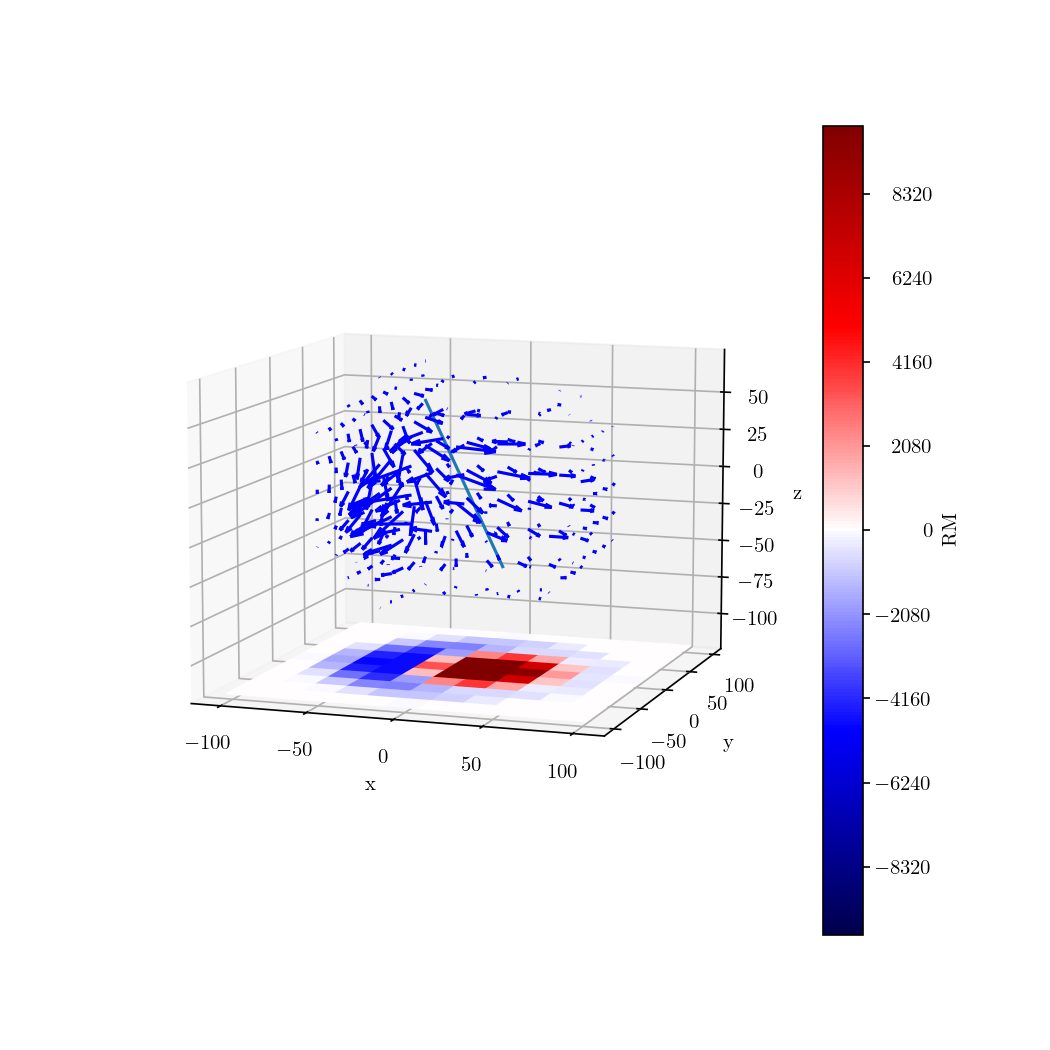

In [22]:
R = 93
b0 = 8.3
make_3d(225, 0)

In [18]:
def make_3d(theta, phi):
    num=11
    # init electron density model
    nel = NelICM(n0 = 39., n2 = 4.05, r_abell = 500., r_core = 80., r_core2 = 280., beta = 1.2, beta2= 0.58, eta = 0.5)
    
    #convert angles to radians
    theta_ = np.radians(theta)
    phi_ = np.radians(phi)
    
    #get rotation
    #incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))    # tilts symmetry axis around x-axis
    pa = R_.from_rotvec(phi_ * np.array([0, 0, 1]))        # rotates around z axis, position angle phi
    
    incl = R_.from_rotvec(theta_ * np.array([1, 0, 0]))
    incl = R_.from_rotvec(B_rot(incl.as_rotvec(), pa))
    
    #dipole
    dipole = R * np.array([[0, 0, -1], [0, 0, 1]])   # N, S
    dip_r = B_rot(dipole, incl)
    #dip_r = B_rot(dip_r,)   # somewhat wrong
    
    #init coordinate space
    x = np.linspace(-R, R, num=num, endpoint=True)
    y = np.linspace(-R, R, num=num, endpoint=True)
    z = np.linspace(-R, R, num=num, endpoint=True)   # (0, R) for front half sphere, (-R, R) for full sphere, (-R, 0) for back
    
    #coordinate meshgrid
    xx, yy, zz = np.meshgrid(x, y, z)
    
    #get magnetic field at each point
    B_r = np.zeros((xx.flatten().shape[0], 3))
    c_list = list(zip(xx.flatten(), yy.flatten(), zz.flatten()))
    for c_, (x_, y_, z_) in enumerate(c_list):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        if np.isnan(theta_):
            #check for previous and next few entries for r=0 and take their theta
            print(c_)
            _, theta_, _ = cart_to_sphere(*c_list[c_ + 1])
        #g = B_cart(r_, theta_, phi_, sys='sph')
        #B_C[c_] = g
        b_temp = B_rot(B(r_, theta_, phi_, 'sph', 'cart'), incl)
        B_r[c_] = b_temp #B_rot(b_temp, pa)
    B_r = B_r.reshape(len(x), len(y), len(z), 3)
    #get rm at each projected point in x-y plane
    rm = np.zeros((x.shape[0],  y.shape[0]))
    rr, _, _ = cart_to_sphere(xx, yy, zz)
    NEL = nel(rr)*1e-3
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            rm[i, j] = rotation_measure(z, B_r[i, j, :, 2], NEL[i, j, :])
    #print(rm)
    
    
    #return xx, yy, zz, B_r
    #theta = np.linspace(0, np.pi/2, num=4)
    #phi = np.array([0])
    #phi = np.linspace(0, np.pi/2, num=8)
    #rr, tt, pp = np.meshgrid(r, theta, phi, indexing='ij')
    #print(rr.shape)
    #xx = np.zeros(rr.flatten().shape)
    #xxr = np.zeros(rr.flatten().shape)
    #yy = np.zeros(rr.flatten().shape)
    #yyr = np.zeros(rr.flatten().shape)
    #zz = np.zeros(rr.flatten().shape)
    #zzr = np.zeros(rr.flatten().shape)
    #b = np.zeros((xx.shape[0], 3))
    #br = np.zeros((xx.shape[0], 3))
    #b_fromr = np.zeros((xx.shape[0], 3))
    
    
    #for c_, (r_, t_, p_) in enumerate(zip(rr.flatten(), tt.flatten(), pp.flatten())):
    #    x, y, z = sphere_to_cart(r_, t_, p_)
    #    xx[c_] = x
    #    yy[c_] = y
    #    zz[c_] = z
    #    b[c_] = B(r_, t_, p_, 'sph', 'cart')
    #    b_fromr[c_] = np.matmul(rot.as_matrix(), b[c_].transpose()).transpose()
    #
    #    #print(x, y, z)
    #    vec_r = np.matmul(rot.as_matrix(), np.array([x, y, z]).transpose()).transpose()
    #    #print(vec_r.shape)
    #    xxr[c_] = vec_r[0]
    #    yyr[c_] = vec_r[1]
    #    zzr[c_] = vec_r[2]
    #    br[c_] = B(*vec_r, 'cart', 'cart')




    fig = plt.figure(figsize=(7, 7))
    #ax1 = fig.add_subplot(1, 2, 1)
    
    
    
    #for p in phi:
    #    x, y, z = sphere_to_cart(r, p, theta)
    #    print(x, y, z)
    #    ax.scatter(x, y, z)
    #xx = xx.reshape(rr.shape)
    #yy = yy.reshape(rr.shape)
    #zz = zz.reshape(rr.shape)
    #print(xx)
    #ax.scatter(xx, yy, zz, s=1)
    ax2 = fig.gca(projection='3d')
    #ax1.set_xlabel('$x [\SI{}{\kilo\parsec}]$')
    #ax1.set_ylabel('$y [\SI{}{\kilo\parsec}]$')
    #ax1.set_xlim(-R, R)
    #ax1.set_ylim(-R, R)
    
    
    xh = axis_helper(x)
    yh = axis_helper(y)
    xxh, yyh = np.meshgrid(xh, yh)
    
    
    #ax2.quiver(xx, yy, zz, B_r[:, :, :, 0], B_r[:, :, :, 1], B_r[:, :, :, 2], length=2)
    ax2.plot(dip_r[:, 0], dip_r[:, 1], dip_r[:, 2])
    #ax.scatter(xxr, yyr, zzr, s=1)
    #ax.quiver(xxr, yyr, zzr, br[:, 0], br[:, 1], br[:, 2], length=0.02)
    #ax.quiver(xxr, yyr, zzr, b_fromr[:, 0], b_fromr[:, 1], b_fromr[:, 2], length=0.02)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    #ax2.set_xlim(-100, 100)
    #ax2.set_ylim(-100, 100)
    #ax2.set_zlim(-100, 100)
    #dx = x[1] - x[0]
    #dy = y[1] - y[0]
    #xx, yy = np.meshgrid(x-dx/2, y-dy/2, indexing='ij')
    #xx, yy = np.meshgrid(x, y, indexing='ij')
    B_r = B_r.reshape((x.shape[0],  y.shape[0],  z.shape[0], 3))
    #ax1.set_xlabel('$x$')
    #ax1.set_ylabel('$y$')
    cmap = plt.get_cmap('seismic')
    #x_h = axis_helper(x)
    #y_h = axis_helper(y)
    levels = MaxNLocator(nbins=cmap.N).tick_values(-1e4, 1e4)
    norm = BoundaryNorm(levels, cmap.N)
    #ax.plot(x, y, zs=0, zdir='z', label='curve in (x,y)')
    scamap = plt.cm.ScalarMappable(norm=norm, cmap='seismic')
    fcolors = scamap.to_rgba(rm)
    pcol = ax2.plot_surface(xxh, yyh, np.full(xxh.shape, -120), cmap='seismic', facecolors=fcolors, alpha=1)
    #cb = fig.colorbar(pcol, ax=ax2, extend='neither', label='RM')
    cb = fig.colorbar(scamap, ax=ax2, extend='neither', label='RM')
    ticklabels = cb.ax.get_yticklabels()
    cb.ax.set_yticklabels(ticklabels, ha='right')
    cb.ax.yaxis.set_tick_params(pad=30)
    
    #create mask that surpresses B field entries pointing in negative z direction
    xx, yy, zz = np.meshgrid(x, y, z)
    
    B_neg = ma.zeros(B_r.shape)
    B_pos = ma.zeros(B_r.shape)
    for i in range(3):
        B_neg[:, :, :, i] = ma.masked_where(B_r[:, :, :, 2]>0, B_r[:, :, :, i]) * NEL * 1e2
        B_pos[:, :, :, i] = ma.masked_where(B_r[:, :, :, 2]<0, B_r[:, :, :, i]) * NEL * 1e2
    #B_pos = ma.masked_where(B_r[:, :, :, 2]<0, B_r[:, :, :, 2])
    xx = ma.masked_array(xx, mask=B_pos.mask[:, :, :, 0])
    yy = ma.masked_array(yy, mask=B_pos.mask[:, :, :, 0])
    #ax2.quiver(xx, yy, zz, np.zeros(xx.shape), np.zeros(xx.shape), B_pos[:, :, :, 2], length=2, color='red')
    
    
    xx, yy, zz = np.meshgrid(x, y, z)
    xx = ma.masked_array(xx, mask=B_neg.mask[:, :, :, 0])
    yy = ma.masked_array(yy, mask=B_neg.mask[:, :, :, 0])
    ax2.quiver(xx, yy, zz, B_neg[:, :, :, 0], B_neg[:, :, :, 1], B_neg[:, :, :, 2] , length=2, color='blue')
    #TODO needs helper axis-meshgrid instead of xx, yy!
    ax2.view_init(azim=-90, elev=90)

In [ ]:
R = 93
b0 = 8.3
make_3d(45, 0)

In [143]:
num=10
x = np.linspace(-R, R, num=num, endpoint=True)
y = np.linspace(-R, R, num=num, endpoint=True)
z = np.linspace(0.01, R, num=num, endpoint=True)   # (0, R) for front half sphere, (-R, R) for full sphere, (-R, 0) for back
dx = x[1] - x[0]
dy = y[1] - y[0]
xx, yy = np.meshgrid(x-dx/2, y-dy/2, indexing='ij')
#coordinate meshgrid
#xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

In [110]:
xx

array([[-1.03333333e+02, -1.03333333e+02, -1.03333333e+02,
        -1.03333333e+02, -1.03333333e+02, -1.03333333e+02,
        -1.03333333e+02, -1.03333333e+02, -1.03333333e+02,
        -1.03333333e+02],
       [-8.26666667e+01, -8.26666667e+01, -8.26666667e+01,
        -8.26666667e+01, -8.26666667e+01, -8.26666667e+01,
        -8.26666667e+01, -8.26666667e+01, -8.26666667e+01,
        -8.26666667e+01],
       [-6.20000000e+01, -6.20000000e+01, -6.20000000e+01,
        -6.20000000e+01, -6.20000000e+01, -6.20000000e+01,
        -6.20000000e+01, -6.20000000e+01, -6.20000000e+01,
        -6.20000000e+01],
       [-4.13333333e+01, -4.13333333e+01, -4.13333333e+01,
        -4.13333333e+01, -4.13333333e+01, -4.13333333e+01,
        -4.13333333e+01, -4.13333333e+01, -4.13333333e+01,
        -4.13333333e+01],
       [-2.06666667e+01, -2.06666667e+01, -2.06666667e+01,
        -2.06666667e+01, -2.06666667e+01, -2.06666667e+01,
        -2.06666667e+01, -2.06666667e+01, -2.06666667e+01,
        -2.

In [108]:
xx

array([[[-93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        ],
        [-93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        ],
        [-93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        ],
        [-93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        ],
        [-93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        ],
        [-93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.        , -93.        , -93.        ,
         -93.        , -93.   

In [9]:
def make_rm(R=93, b0=8.3, theta=0, phi=0, num=10):
    #th in degrees
    nel = NelICM(n0 = 39., n2 = 4.05, r_abell = 500., r_core = 80., r_core2 = 280., beta = 1.2, beta2= 0.58, eta = 0.5)
    theta_rad = np.radians(theta)
    e_x = np.array([1, 0, 0])
    dipole = np.array([[0, 0, -1], [0, 0, 1]])   # N, S
    #init coordinate space
    x = np.linspace(-R, R, num=num)
    y = np.linspace(-R, R, num=num)
    #x = np.array([0])
    #y = np.array([0])
    z = np.linspace(0, R, num=num)
    
    #get meshgrid
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    rotx, rotz = cart_rotation(np.radians(theta), np.radians(phi))
    rotxz = np.matmul(rotx, rotz)    # first rotate around LOS, then tilt w.r.t. LOS.
    # should be wrong like this! needs rotation around the tilted normal/LOS vector!
    XR = np.zeros(X.shape).flatten()
    YR = np.zeros(Y.shape).flatten()
    ZR = np.zeros(Z.shape).flatten()
    
    # rotate integration direction, i.e. e_y
    e_z = np.array([0, 0, 1])
    r_e_z = np.matmul(rotx, e_z.transpose()).transpose()
    r_e_x = np.matmul(rotz, e_x.transpose()).transpose()
    r_dipole = np.zeros(dipole.shape)
    r_dipole[0] = rotation(r_e_x, dipole[0], np.radians(theta))
    r_dipole[1] = rotation(r_e_x, dipole[1], np.radians(theta))
    #print(r_dipole)

    # rotate coordinate grid
    for c_, (x_, y_, z_) in enumerate(zip(X.flatten(), Y.flatten(), Z.flatten())):
        rot = np.matmul(rotxz, np.array([x_, y_, z_]).transpose()).transpose()
        XR[c_] = rot[0]
        YR[c_] = rot[1]
        ZR[c_] = rot[2]
    
    XR = XR.reshape(X.shape)
    YR = YR.reshape(Y.shape)
    ZR = ZR.reshape(Z.shape)
    B_C = np.zeros((x.shape[0] * y.shape[0] * z.shape[0], 3))
    c_list = list(zip(XR.flatten(), YR.flatten(), ZR.flatten()))
    for c_, (x_, y_, z_) in enumerate(c_list):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        #print(r_, theta_, phi_)
        if np.isnan(theta_):
            #check for previous and next few entries for r=0 and take their theta
            print(c_)
            _, theta_, _ = cart_to_sphere(*c_list[c_ + 1])
        g = B_cart(r_, theta_, phi_, sys='sph')
        B_C[c_] = g
        #print(g)
    R_mesh, _, _ = cart_to_sphere(XR, YR, ZR)
    NEL = nel(R_mesh)*1e-3
    B_C = B_C.reshape((x.shape[0], y.shape[0], z.shape[0], 3))
    #print(r_e_y)
    #print(B_C.shape)
    #print("B_C")
    #print(B_C)
    B_proj = np.inner(B_C, r_e_z)
    #print("b_proj")
    #print(B_proj.shape)
    print("LOS", r_e_z)
    rm = np.zeros((x.shape[0], y.shape[0]))
    #print(NEL)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            rm[i, j] = rotation_measure(z, B_proj[i, j, :], NEL[i, j, :])

    return x, y, z, r_dipole, rm
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(X, Y, Z)
    ax.scatter(XR, YR, ZR)
    ax.plot([0, e_z[0]], [0, e_z[1]], [0, e_z[2]])
    ax.plot([0, r_e_z[0]], [0, r_e_z[1]], [0, r_e_z[2]])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

1680
LOS [ 0.000000e+00 -1.000000e+00  6.123234e-17]


/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


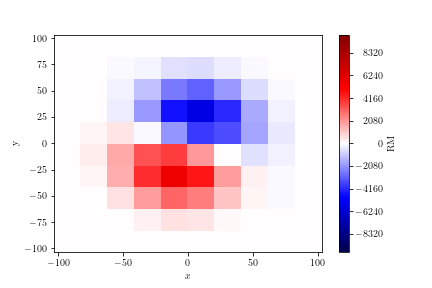

"\niax = ax.inset_axes([0, 0, 0.23, 0.23])\niax.set_xlim(-1.15, 1.15)\niax.set_ylim(-1.15, 1.15)\niax.scatter(dip[:, 0], dip[:, 1], c=['red', 'green'])\nrect = [0.45, 0.6, 0.3, 0.3]\nax_inset = fig.add_axes(rect, anchor='NE', projection='3d')\nax_inset.view_init(elev=theta+90, azim=90+phi)\nax_inset.scatter(*dip[0], c='red')\nax_inset.scatter(*dip[1], c='green')\nax_inset.patch.set_alpha(0.)\n#iax.set_xticks([], [])\n#iax.set_yticks([], [])\n"

In [11]:
R = 93
b0 = 8.3
phi = 0
theta = 90
#make_rm(theta=theta, phi=phi, num=20)
x, y, z, dip, rm = make_rm(theta=theta, phi=phi, num=15)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
cmap = plt.get_cmap('seismic')
x_h = axis_helper(x)
y_h = axis_helper(y)
levels = MaxNLocator(nbins=cmap.N).tick_values(-1e4, 1e4)
norm = BoundaryNorm(levels, cmap.N)
pcol = ax.pcolor(x_h, y_h, rm, cmap=cmap, norm=norm, alpha=1)
cb = fig.colorbar(pcol, ax=ax, extend='neither', label='RM')
ticklabels = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabels, ha='right')
cb.ax.yaxis.set_tick_params(pad=30)
ax.set_xlabel('$x [\SI{}{\kilo\parsec}]$')
ax.set_ylabel('$y [\SI{}{\kilo\parsec}]$')
'''
iax = ax.inset_axes([0, 0, 0.23, 0.23])
iax.set_xlim(-1.15, 1.15)
iax.set_ylim(-1.15, 1.15)
iax.scatter(dip[:, 0], dip[:, 1], c=['red', 'green'])
rect = [0.45, 0.6, 0.3, 0.3]
ax_inset = fig.add_axes(rect, anchor='NE', projection='3d')
ax_inset.view_init(elev=theta+90, azim=90+phi)
ax_inset.scatter(*dip[0], c='red')
ax_inset.scatter(*dip[1], c='green')
ax_inset.patch.set_alpha(0.)
#iax.set_xticks([], [])
#iax.set_yticks([], [])
'''


In [ ]:
rm

In [ ]:
R = 3
b0 = 8.3
phi = 0
theta = 85
%matplotlib notebook
make_rm(R=R, b0=b0, num=4, theta=theta, phi=phi)

In [ ]:
R = 93
x = 30
y = np.linspace(-R, R, num=10)
z = 0
# xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
integral = 0
for y_ in y:
    bc = B_cart(x, y_, z, sys='cart')
    r, _, _ = cart_to_sphere(x, y_, z)
    
    print(bc)
    integral += nel(r)*1e-3 * np.inner(bc, np.array([0, -1, 0]))
print(integral)

In [ ]:
fig.savefig('rm_theta_45_90.png')

In [ ]:
n = np.array([0, 1])
plt.plot((0, 0), (0, 1))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [85]:
a = np.array([1, 2])
a_m = ma.masked_where(a>1, a)
print(a_m)
print(a_m.mask)
print((type(a_m)))

[1 --]
[False  True]
<class 'numpy.ma.core.MaskedArray'>


In [17]:
for v in ["a", "b", "c"]: locals()[v] = np.zeros(3)